# **Introduction**

**<font size="3.5">_This notebook is built under Capstone Project `Healthcare Detection of Indications using Image Processing (ML and DL)`. In this notebook, we are building the model for skin lesions by training the model on HAM10000 dataset_</font>**

## **Part 1: Data Processing**

### **Import Standard Libraries**

In [1]:
import numpy as np #For numerical calculations
import pandas as pd

import matplotlib.pyplot as plt #For Visualization

import tensorflow as tf #For Implementation of Deep Learning Models
from tensorflow import keras #Keras library to import raw ingredients for ConvNet Deep Learning Model
from keras import layers, initializers #To add Layers and Weights to the layers, respectively
from keras.models import Sequential #To group a linear stack of layers for ConvNet model
from keras import preprocessing #To perform preprocessing operations on the data to make it ready for model building
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array #To perform Image Data Augmentation and to view the
                                                                                #augmented images by converting them into arrayed format

#Import Various Layers for add fully connected layer, Convolution layer, Pooling Layers, Dropout layer, Flattening the inputs
from keras.layers import Dense, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, Flatten
from keras.regularizers import l1, l2 #To add penalty as regularizer
from keras.callbacks import EarlyStopping #For Early Stopping the model before running the specified number of epochs

import os #Module to interact with operating system

from warnings import filterwarnings #To ignore warnings
filterwarnings("ignore")

In [2]:
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator


### **Read the Metadata**

In [3]:
import chardet

# use the detect method to find the encoding
# 'rb' means read in the file as binary
with open("HAM10000/HAM10000_metadata.csv", 'rb') as file:
    print(chardet.detect(file.read()))

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}


In [4]:
metadata = pd.read_csv("HAM10000/HAM10000_metadata.csv", encoding='Windows-1252')

In [5]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern


### **Calculate the number of Images in each Class Label**

In [6]:
metadata["dx"].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

**<font size="4">_This indicates that the dataset is imbalanced in nature. This needs to be rectified._</font>**

In [7]:
import glob
import matplotlib.image as mpimg
%matplotlib inline

### **Plot the Images**

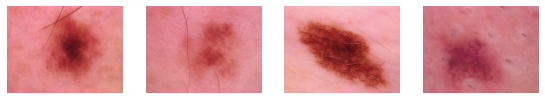

In [8]:
images = []
for img_path in glob.glob('HAM10000/HAM10000_images_part_1/ISIC_002430*.jpg'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(12,8))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)
    plt.axis("off")

**<font size="4">_Images are distributed in two different folders. We need to identify the folder under which the image is present._</font>**

In [9]:
import os

image_folder_1 = "HAM10000/HAM10000_images_part_1"
image_folder_2 = "HAM10000/HAM10000_images_part_2"

metadata["folder"] = 0
metadata.set_index("image_id", drop=False, inplace=True)

for image in os.listdir(image_folder_1):
    image_id = image.split(".")[0]
    metadata.loc[image_id, "folder"] = "1"

for image in os.listdir(image_folder_2):
    image_id = image.split(".")[0]
    metadata.loc[image_id, "folder"] = "2"

In [10]:
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,folder
image_id,,,,,,,,,
ISIC_0027419,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,1
ISIC_0025030,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,1
ISIC_0026769,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,1
ISIC_0025661,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,1
ISIC_0031633,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,2


### **Check for NaN values in the dataset**

In [11]:
metadata.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dataset          0
folder           0
dtype: int64

**<font size="4">_On observing closely, there are some rows in the dataset where age is NaN. We can replace the NaN value with the average age._</font>**

In [12]:
mean_age = np.round(metadata["age"].mean(),2)
print(mean_age)

51.86


In [13]:
metadata["age"].fillna(mean_age, inplace=True)
metadata.isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dataset         0
folder          0
dtype: int64

### **Split the Data into Train, Validation and Test Sets**

In the below code cell, we are splitting the metadata into training, validation and test sets in the ratio 60:20:20 respectively.

In [14]:
data_train_1, data_test = train_test_split(metadata, test_size=0.20, stratify=metadata["dx"])
#data_train = pd.concat((data_train_1, metadata), axis=0)
data_train, data_val = train_test_split(data_train_1, test_size=0.25, stratify=data_train_1["dx"])

print("Train: " + str(data_train.shape[0] / metadata.shape[0]))
print("Validation: " + str(data_val.shape[0] / metadata.shape[0]))
print("Test: " + str(data_test.shape[0] / metadata.shape[0]))
val_len = data_val.shape[0]
test_len = data_test.shape[0]

Train: 0.6
Validation: 0.2
Test: 0.2


In [15]:
import shutil

In [16]:
base_dir = "data"
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, "image_train")
os.mkdir(train_dir)

val_dir = os.path.join(base_dir, "image_val")
os.mkdir(val_dir)

test_dir = os.path.join(base_dir, "image_test")
os.mkdir(test_dir)

labels = list(metadata["dx"].unique())

for label in labels:
    label_path_train = os.path.join(train_dir, label)
    os.mkdir(label_path_train)
    label_path_val = os.path.join(val_dir, label)
    os.mkdir(label_path_val)
    label_path_test = os.path.join(test_dir, label)
    os.mkdir(label_path_test)

### Copy Images to respective folders

In [17]:
image_dir = "HAM10000/HAM10000_images_part_"

for i in range(data_train.shape[0]):
    image_name = data_train["image_id"][i] + ".jpg"
    src_dir = os.path.join(image_dir + data_train["folder"][i], image_name)
    dst_dir = os.path.join(train_dir, data_train["dx"][i], image_name)
    shutil.copyfile(src_dir, dst_dir)

for i in range(data_val.shape[0]):
    image_name = data_val["image_id"][i] + ".jpg"
    src_dir = os.path.join(image_dir + data_val["folder"][i], image_name)
    dst_dir = os.path.join(val_dir, data_val["dx"][i], image_name)
    shutil.copyfile(src_dir, dst_dir)
    
for i in range(data_test.shape[0]):
    image_name = data_test["image_id"][i] + ".jpg"
    src_dir = os.path.join(image_dir + data_test["folder"][i], image_name)
    dst_dir = os.path.join(test_dir, data_test["dx"][i], image_name)
    shutil.copyfile(src_dir, dst_dir)

### **Number of Images in each Folder**

In [18]:
print("TRAIN:")
for label in labels:
    print(label + "\t "+ str(len(os.listdir(os.path.join(train_dir, label)))))
print("\n")

print("VAL:")
for label in labels:
    print(label + "\t " + str(len(os.listdir(os.path.join(val_dir, label)))))
print("\n")

print("TEST:")
for label in labels:
    print(label + "\t "+ str(len(os.listdir(os.path.join(test_dir, label)))))
print("\n")

TRAIN:
bkl	 659
nv	 4023
df	 69
mel	 668
vasc	 86
bcc	 308
akiec	 196


VAL:
bkl	 220
nv	 1341
df	 23
mel	 222
vasc	 28
bcc	 103
akiec	 66


TEST:
bkl	 220
nv	 1341
df	 23
mel	 223
vasc	 28
bcc	 103
akiec	 65


